## 1. Introduction

For this project we use Secondary data of "Mushroom data set".

This dataset includes 61069 hypothetical mushrooms with caps based on 173 species (353 mushrooms
per species).

 Each mushroom is identified as definitely edible, definitely poisonous, or of
unknown edibility and not recommended (the latter class was combined with the poisonous class).

## 2. Connection to Spark Cluster

To connect to the Spark cluster, create a SparkSession object with the app name "Classification"

In [25]:

from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline


spark = SparkSession.builder.appName('classification').config("spark.sql.shuffle.partitions", "100") .config("spark.sql.debug.maxToStringFields", "1000").getOrCreate()

print('Spark Version: {}'.format(spark.version))


Spark Version      : 3.5.1


## 3. Data Preparation


We will now load data from a local CSV and store it to Hadoop partitioned by column. Afterward you can access Hadoop UI to explore the saved parquet files. Access Hadoop UI on 'http://bigdata:9870' (Utilities -> Browse the files system )

In [26]:
import pandas as pd
import numpy as np
from pyspark.sql.types import *
from pyspark.sql import functions as F
import os
import time

## Load:

In [27]:
df = pd.read_csv('secondary_data.csv',sep=";")
df.head(10)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w
5,p,15.34,x,g,o,f,e,NaN,w,17.84,...,s,y,w,u,w,t,p,NaN,d,u
6,p,14.85,f,h,o,f,e,NaN,w,17.71,...,s,y,w,u,w,t,g,NaN,d,w
7,p,14.86,x,h,e,f,e,NaN,w,17.03,...,s,y,w,u,w,t,p,NaN,d,u
8,p,12.85,f,g,o,f,e,NaN,w,17.27,...,s,y,w,u,w,t,p,NaN,d,a
9,p,13.55,f,g,e,f,e,NaN,w,16.04,...,s,y,w,u,w,t,p,NaN,d,w


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

In [29]:
num_rows =df.shape[0]
print("Number of rows:", num_rows)

Number of rows: 61069


In [30]:
df.nunique()

class                      2
cap-diameter            2571
cap-shape                  7
cap-surface               11
cap-color                 12
does-bruise-or-bleed       2
gill-attachment            7
gill-spacing               3
gill-color                12
stem-height             2226
stem-width              4630
stem-root                  5
stem-surface               8
stem-color                13
veil-type                  1
veil-color                 6
has-ring                   2
ring-type                  8
spore-print-color          7
habitat                    8
season                     4
dtype: int64

###  Check for missing values
Check for missing values and handle them appropriately (e.g. fill missing values with mean, median, or mode).

In [31]:
df.isnull().sum()

class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64

In [32]:
object_cols = df.select_dtypes(include=['object']).columns
print(object_cols)


df_mean_imputed = df.copy()
threshold = 0.6
df_mean_imputed = df.dropna(axis=1, thresh=len(df) * (1 - threshold) )
object_cols = df_mean_imputed.select_dtypes(include=['object']).columns
print(df_mean_imputed.shape)

for col in object_cols:
    mode_value = df_mean_imputed[col].mode()[0]
    df_mean_imputed.loc[:, col] = df_mean_imputed[col].fillna(mode_value)



df_mean_imputed.isnull().sum()

Index(['class', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color',
       'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season'],
      dtype='object')
(61069, 16)


class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

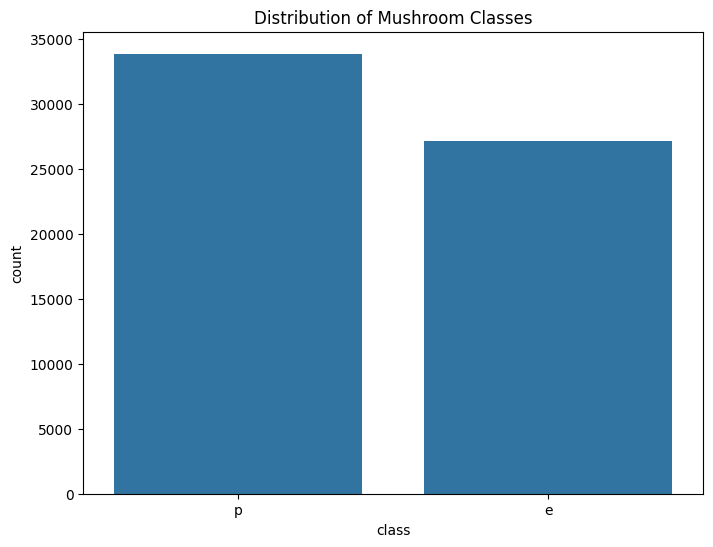

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df)
plt.title('Distribution of Mushroom Classes')
plt.show()

In [34]:
spark_df = spark.createDataFrame(df_mean_imputed)

###  Set number of partitions:

This code pertains to Apache Spark and is commonly employed to enhance the performance of Spark DataFrames.
Repartitioning can enhance parallelism and boost the efficiency of specific operations.
The cache method is employed to retain the DataFrame in memory. Caching involves storing the DataFrame in memory, which can accelerate iterative algorithms or repeated operations on the same DataFrame by avoiding recomputation.
The unpersist method is utilized to eliminate the DataFrame from the cache. It frees up the memory allocated for caching. This is typically done when the cached DataFrame is no longer necessary, allowing for the release of resources.

In [35]:
number_of_partitions = spark_df.rdd.getNumPartitions()
print("Number of partitions:", number_of_partitions)

Number of partitions: 4


In [36]:
spark_df = spark_df.repartition(7)
spark_df.cache()
spark_df.unpersist();

In [37]:
number_of_partitions =spark_df.rdd.getNumPartitions()
print("Number of partitions:", number_of_partitions)

Number of partitions: 7


In [38]:
spark_df = spark_df.na.replace("?", None)
spark_df = spark_df.dropna()
spark_df.printSchema()
spark_df.schema

root
 |-- class: string (nullable = true)
 |-- cap-diameter: double (nullable = true)
 |-- cap-shape: string (nullable = true)
 |-- cap-surface: string (nullable = true)
 |-- cap-color: string (nullable = true)
 |-- does-bruise-or-bleed: string (nullable = true)
 |-- gill-attachment: string (nullable = true)
 |-- gill-spacing: string (nullable = true)
 |-- gill-color: string (nullable = true)
 |-- stem-height: double (nullable = true)
 |-- stem-width: double (nullable = true)
 |-- stem-color: string (nullable = true)
 |-- has-ring: string (nullable = true)
 |-- ring-type: string (nullable = true)
 |-- habitat: string (nullable = true)
 |-- season: string (nullable = true)



StructType([StructField('class', StringType(), True), StructField('cap-diameter', DoubleType(), True), StructField('cap-shape', StringType(), True), StructField('cap-surface', StringType(), True), StructField('cap-color', StringType(), True), StructField('does-bruise-or-bleed', StringType(), True), StructField('gill-attachment', StringType(), True), StructField('gill-spacing', StringType(), True), StructField('gill-color', StringType(), True), StructField('stem-height', DoubleType(), True), StructField('stem-width', DoubleType(), True), StructField('stem-color', StringType(), True), StructField('has-ring', StringType(), True), StructField('ring-type', StringType(), True), StructField('habitat', StringType(), True), StructField('season', StringType(), True)])

### One Hot Encoding Categorical data type columns

In [67]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

categorical_columns = [spark_df.columns[i] for i in list(range(11, 16))+[0]+[2]+[3]+[4]+[5]+[6]+[7]+[8] ]

indexer_output_names = [name + "__indexed" for name in categorical_columns]
encoder_output_names = [name + "__vec" for name in categorical_columns]

indexer = StringIndexer(inputCols=categorical_columns, outputCols=indexer_output_names)
onehoter = OneHotEncoder(inputCols=indexer_output_names, outputCols=encoder_output_names)

indexed_df = indexer.fit(spark_df).transform(spark_df)
one_hoted_df = onehoter.fit(indexed_df).transform(indexed_df)

label_indexer = StringIndexer(inputCol='class', outputCol='label')
one_hoted_df = label_indexer.fit(one_hoted_df).transform(one_hoted_df)

one_hoted_df = one_hoted_df.select([F.col(col) for col in one_hoted_df.columns
                                          if "__vec" in col or col not in categorical_columns and "__indexed" not in col])
processed_spark_df = one_hoted_df.select([F.col(col) for col in one_hoted_df.columns if col != "class"])
processed_spark_df.printSchema()
processed_spark_df.show(10)

root
 |-- cap-diameter: double (nullable = true)
 |-- stem-height: double (nullable = true)
 |-- stem-width: double (nullable = true)
 |-- stem-color__vec: vector (nullable = true)
 |-- has-ring__vec: vector (nullable = true)
 |-- ring-type__vec: vector (nullable = true)
 |-- habitat__vec: vector (nullable = true)
 |-- season__vec: vector (nullable = true)
 |-- class__vec: vector (nullable = true)
 |-- cap-shape__vec: vector (nullable = true)
 |-- cap-surface__vec: vector (nullable = true)
 |-- cap-color__vec: vector (nullable = true)
 |-- does-bruise-or-bleed__vec: vector (nullable = true)
 |-- gill-attachment__vec: vector (nullable = true)
 |-- gill-spacing__vec: vector (nullable = true)
 |-- gill-color__vec: vector (nullable = true)
 |-- label: double (nullable = false)



+------------+-----------+----------+---------------+-------------+--------------+-------------+-------------+-------------+--------------+----------------+--------------+-------------------------+--------------------+-----------------+---------------+-----+
|cap-diameter|stem-height|stem-width|stem-color__vec|has-ring__vec|ring-type__vec| habitat__vec|  season__vec|   class__vec|cap-shape__vec|cap-surface__vec|cap-color__vec|does-bruise-or-bleed__vec|gill-attachment__vec|gill-spacing__vec|gill-color__vec|label|
+------------+-----------+----------+---------------+-------------+--------------+-------------+-------------+-------------+--------------+----------------+--------------+-------------------------+--------------------+-----------------+---------------+-----+
|       12.44|      11.39|     15.42| (12,[0],[1.0])|    (1,[],[])| (7,[1],[1.0])|(7,[0],[1.0])|(3,[1],[1.0])|(1,[0],[1.0])| (6,[1],[1.0])|  (10,[0],[1.0])|(11,[0],[1.0])|            (1,[0],[1.0])|       (6,[4],[1.0])|    (

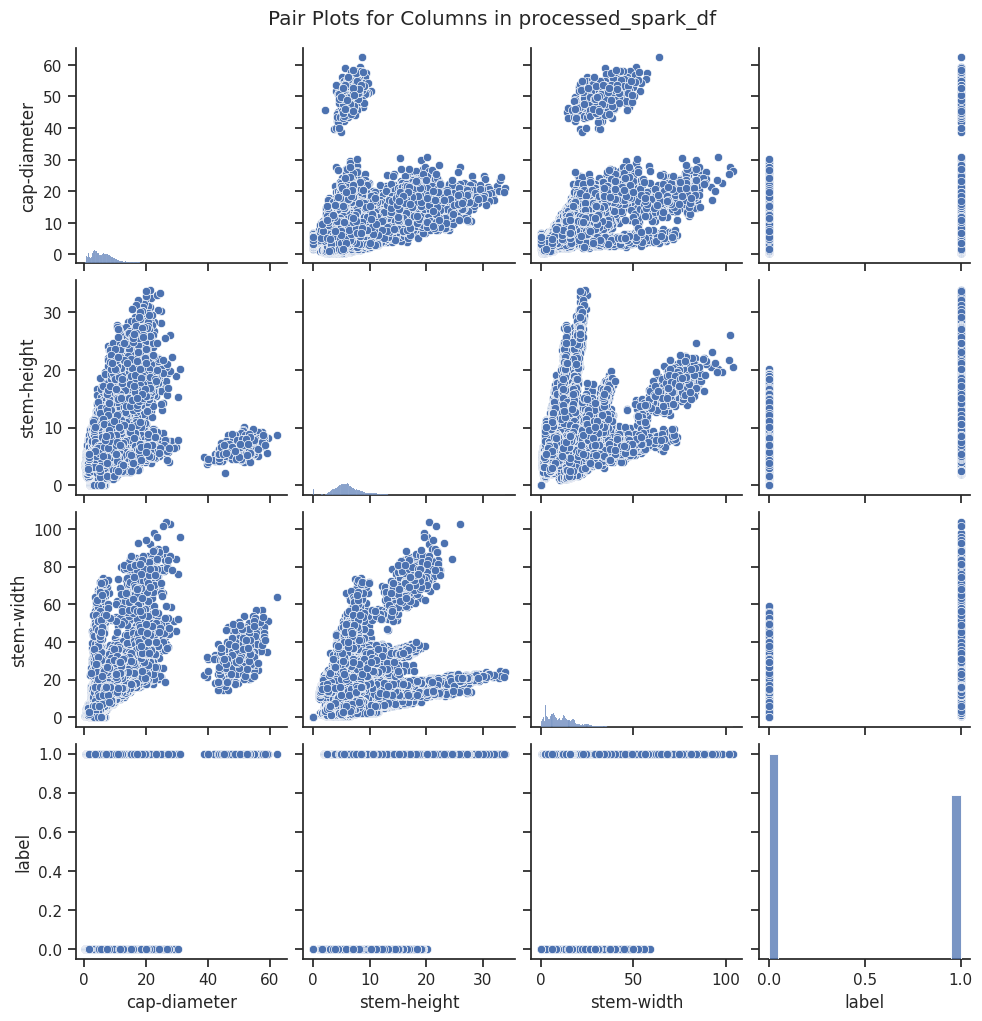

In [53]:
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt


# Convert Spark DataFrame to Pandas for visualization
pd_df = processed_spark_df.toPandas()

# Create pair plots using Seaborn
sns.set(style="ticks")
sns.pairplot(pd_df)
plt.suptitle('Pair Plots for Columns in processed_spark_df', y=1.02)
plt.show()


###  Train & Test split

In [59]:
from pyspark.ml.feature import VectorAssembler

input_cols = processed_spark_df.columns

seed = 42
data_train, data_test = processed_spark_df.randomSplit([0.7, 0.3], seed=seed)
# Use the VectorAssembler to combine the feature columns into a single vector column
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')

# Use the assembler to transform the dataset
data_train = assembler.transform(data_train)
data_test = assembler.transform(data_test)

## 4. Model selection
Choose an appropriate classification model  based on the size and characteristics of the dataset and the problem we are trying to solve.

In [64]:
from pyspark.ml.classification import LogisticRegression
# Create a logistic regression object
logr = LogisticRegression(featuresCol='features', labelCol='label')
from pyspark.ml.classification import DecisionTreeClassifier
# Train a decision tree classifier on the training data
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')
from pyspark.ml.classification import RandomForestClassifier
# Create the Random Forest Classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='label')
from pyspark.ml.classification import LinearSVC
svm = LinearSVC(featuresCol='features', labelCol='label')
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol='features', labelCol='label')
# Fit the models on the training data
lr_model = logr.fit(data_train)
dt_model = dt.fit(data_train)
rf_model = rf.fit(data_train)
svm_model = svm.fit(data_train)
gbt_model = gbt.fit(data_train)

done


## 6. Model Evaluation
Evaluate the performance of the model on the testing data using appropriate metrics such as accuracy, precision, recall, F1-score, confusion matrix, etc.

In [66]:
lr_predictions = lr_model.transform(data_test)
dt_predictions = dt_model.transform(data_test)
rf_predictions = rf_model.transform(data_test)
svm_predictions = svm_model.transform(data_test)
gbt_predictions = gbt_model.transform(data_test)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def prec_recall(predictions):
    # Instantiate a MulticlassClassificationEvaluator
    evaluator = MulticlassClassificationEvaluator(metricName="weightedPrecision", labelCol="label")

    # Calculate precision, recall, and F1-score
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

    return precision, recall


lr_prec_recall = prec_recall(lr_predictions)
dt_prec_recall = prec_recall(dt_predictions)
rf_prec_recall = prec_recall(rf_predictions)
svm_prec_recall = prec_recall(svm_predictions)
gbt_prec_recall = prec_recall(gbt_predictions)
print('Linear Regression:')
print('precision = {:.2f}\nrecall   = {:.2f}'.format(*lr_prec_recall))
print('Decision tree classifier:')
print('precision = {:.2f}\nrecall   = {:.2f}'.format(*dt_prec_recall))
print('Random Forest classifier:')
print('precision = {:.2f}\nrecall   = {:.2f}'.format(*rf_prec_recall))
print('SVM classifier:')
print('precision = {:.2f}\nrecall   = {:.2f}'.format(*svm_prec_recall))
print('GBT classifier:')
print('precision = {:.2f}\nrecall   = {:.2f}'.format(*gbt_prec_recall))

Linear Regression:
precision = 1.00
recall   = 1.00
Decision tree classifier:
precision = 1.00
recall   = 1.00
Random Forest classifier:
precision = 1.00
recall   = 1.00
SVM classifier:
precision = 1.00
recall   = 1.00
GBT classifier:
precision = 1.00
recall   = 1.00
